In [3]:
! pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import math

In [5]:
# Load the dataset
file_path = 'daily_aqi_result.csv'
aqi_data = pd.read_csv(file_path)
aqi_data['date'] = pd.to_datetime(aqi_data['date'], format='%d-%m-%Y')
aqi_data.set_index('date', inplace=True)

In [6]:
# Ensure all feature columns are numeric
aqi_data = aqi_data.apply(pd.to_numeric, errors='coerce')


In [7]:
aqi_data.head()

,PM10,PM2.5,NO,NO2,NOX,CO,SO2,NH3,Ozone,Benzene,AQI
date,,,,,,,,,,,
2023-02-01,114.739583,35.145833,14.428266,78.831797,48.530026,0.449284,35.620127,22.146269,32.386064,0.232292,110.128985
2023-02-02,177.458333,52.020833,14.428266,79.055371,53.576805,1.279423,35.620127,22.409227,25.875865,0.120801,151.801175
2023-02-03,171.270833,52.916667,14.428266,82.263043,56.639537,1.197265,35.620127,23.193211,27.709662,0.165625,147.690017
2023-02-04,191.527249,70.690232,14.428266,76.674860,53.341595,1.124689,35.620127,25.273148,27.588217,0.185188,161.148977
2023-02-05,225.061703,77.524592,14.428266,72.368352,63.216050,0.883730,35.620127,25.979271,24.179688,0.212001,183.430259


In [8]:
# Separate features and target
features = [col for col in aqi_data.columns if col != 'AQI']
X = aqi_data[features]
y = aqi_data['AQI']

In [9]:
# Train-test split
train_size = int(len(aqi_data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(y_train)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -5.923528008905217
p-value: 2.474251181054313e-07


### ADF Test Results

- **ADF Statistic**: **-5.9235**
  - This value is significantly smaller (more negative) than common critical values for 1%, 5%, and 10% significance levels (e.g., around **-3.5**, **-2.9**, and **-2.6**, respectively, depending on the test setup).
  - This indicates **strong evidence to reject the null hypothesis**.

- **p-value**: **2.474 × 10⁻⁷**
  - The p-value is far below the typical significance threshold of **0.05**, which strongly supports rejecting the null hypothesis.
  - This means the series **does not have a unit root**, and it is **stationary**.


In [11]:
# Apply scaling
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

In [12]:
X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test)
y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))

In [13]:
# Plot function for predictions
def plot_predictions(test, predictions, title):
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test, label='Actual AQI', color='blue')
    plt.plot(test.index, predictions, label='Predicted AQI', color='orange')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.legend()
    plt.grid(True)
    plt.show()


# Model 1: ARIMA (Auto-Regressive Integrated Moving Average)


--- Model 1: AutoARIMA ---
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=969.323, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=845.360, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=917.434, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=841.826, Time=0.18 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=839.067, Time=0.25 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=836.392, Time=0.63 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=837.577, Time=1.93 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.67 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=1.40 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.89 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=824.603, Time=0.39 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=822.978, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=820.970, Time=0.40 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept  

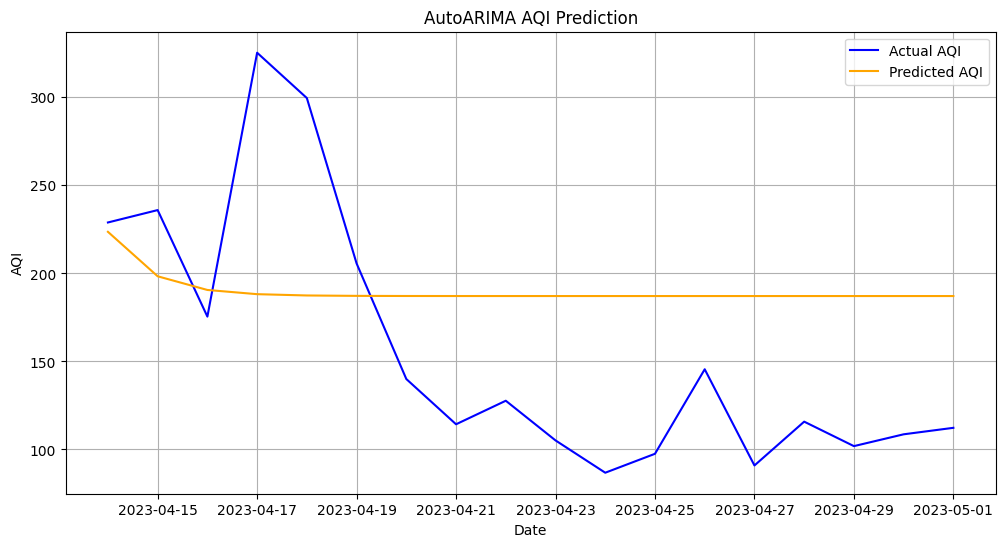

In [14]:
print("\n--- Model 1: AutoARIMA ---")
auto_arima_model = auto_arima(y_train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
arima_predictions = auto_arima_model.predict(n_periods=len(y_test))
arima_mae = mean_absolute_error(y_test, arima_predictions)
arima_rmse = math.sqrt(mean_squared_error(y_test, arima_predictions))
print(f"AutoARIMA MAE: {arima_mae}, RMSE: {arima_rmse}")
plot_predictions(y_test, arima_predictions, 'AutoARIMA AQI Prediction')

# Model 2: SARIMAX


--- Model 1: SARIMAX with Exogenous Variables ---


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX MAE: 35.820337497316984, RMSE: 55.33102910505375


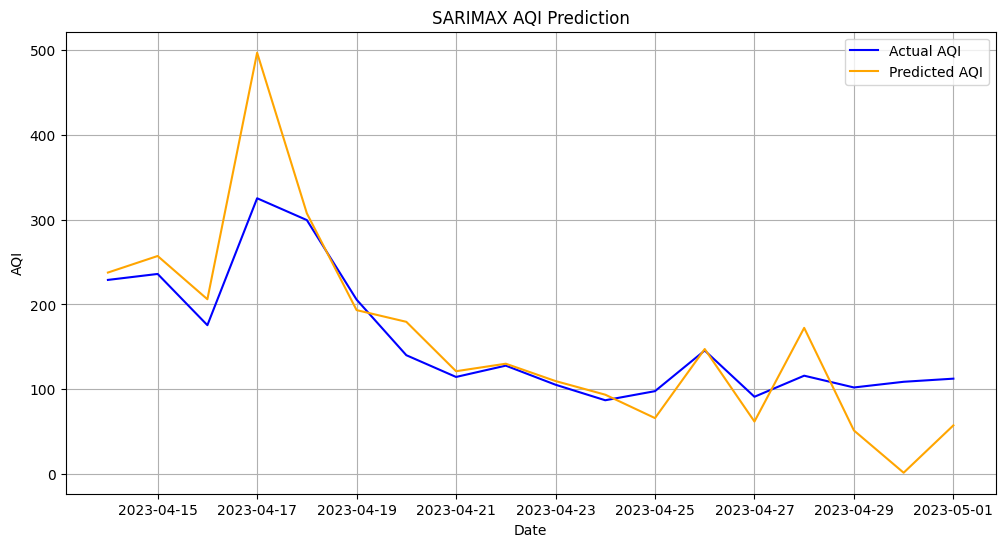

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

aqi_data.index.freq = 'D'

# Step 1: Prepare SARIMAX with Exogenous Features
print("\n--- Model 1: SARIMAX with Exogenous Variables ---")
# Use pollutant features as exogenous variables (scaled)
exogenous_train = X_train_scaled
exogenous_test = X_test_scaled

# Fit SARIMAX model (manual tuning of parameters)
sarimax_model = SARIMAX(
    y_train,
    exog=exogenous_train,
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 7)
)
# sarimax_fit = sarimax_model.fit(disp=False)
# sarimax_fit = sarimax_model.fit(disp=False, method='powell')
sarimax_fit = sarimax_model.fit(disp=False, method='lbfgs')


# Step 2: Predict using SARIMAX
sarimax_predictions = sarimax_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=exogenous_test)

# Step 3: Evaluate SARIMAX Performance
sarimax_mae = mean_absolute_error(y_test, sarimax_predictions)
sarimax_rmse = math.sqrt(mean_squared_error(y_test, sarimax_predictions))
print(f"SARIMAX MAE: {sarimax_mae}, RMSE: {sarimax_rmse}")


plot_predictions(y_test, sarimax_predictions, 'SARIMAX AQI Prediction')




# Model 2: Random Forest


--- Model 2: Random Forest ---
Random Forest MAE: 12.286896248911113, RMSE: 17.318862024005686


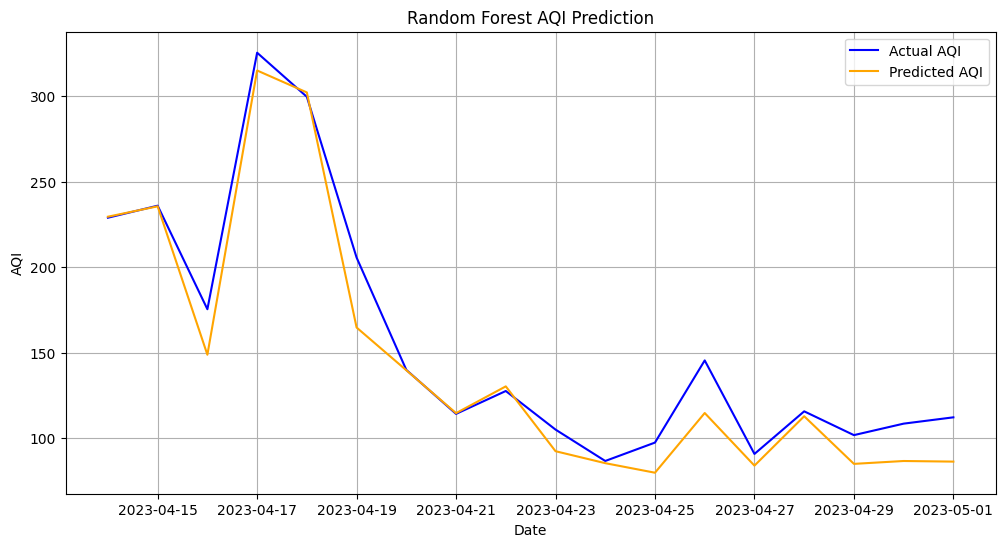

In [16]:
# Model 2: Random Forest
print("\n--- Model 2: Random Forest ---")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_predictions = rf.predict(X_test_scaled)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = math.sqrt(mean_squared_error(y_test, rf_predictions))
print(f"Random Forest MAE: {rf_mae}, RMSE: {rf_rmse}")
plot_predictions(y_test, rf_predictions, 'Random Forest AQI Prediction')

# Model 4 : RNNs

In [17]:
# Prepare data for GRU and LSTM
def prepare_sequence_data(X, y, timesteps=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps])
    return np.array(X_seq), np.array(y_seq)

In [18]:
timesteps = 5
X_train_seq, y_train_seq = prepare_sequence_data(X_train_scaled, y_train_scaled, timesteps)
X_test_seq, y_test_seq = prepare_sequence_data(X_test_scaled, y_test_scaled, timesteps)

## Model 4.1 GRU

In [27]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model

def build_gru_model(units, dropout_rate, learning_rate, input_shape):
    input_layer = Input(shape=input_shape)  # Define the input layer explicitly
    x = GRU(units, return_sequences=True)(input_layer)
    x = Dropout(dropout_rate)(x)
    x = GRU(units)(x)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(1)(x)  # Output layer for regression
    model = Model(inputs=input_layer, outputs=output_layer)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model



In [28]:
# Hyperparameter grid
param_grid = {
    'units': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'batch_size': [16, 32, 64],
    'epochs': [20]  # Can add more if needed
}


In [30]:
from sklearn.model_selection import ParameterGrid
from keras.callbacks import EarlyStopping

# Prepare input data
timesteps = 5
X_train_seq, y_train_seq = prepare_sequence_data(X_train_scaled, y_train_scaled, timesteps)
X_test_seq, y_test_seq = prepare_sequence_data(X_test_scaled, y_test_scaled, timesteps)

# Initialize variables to track the best configuration
best_model = None
best_mae = float('inf')
best_params = None
results = []

# Perform Grid Search
for params in ParameterGrid(param_grid):
    print(f"Testing params: {params}")
    # Build model
    model = build_gru_model(
        units=params['units'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    )
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0,
        callbacks=[early_stopping]
    )

    # Evaluate the model
    predictions = model.predict(X_test_seq)
    predictions = scaler_target.inverse_transform(predictions)
    y_test_actual = scaler_target.inverse_transform(y_test_seq)
    mae = mean_absolute_error(y_test_actual, predictions)
    rmse = math.sqrt(mean_squared_error(y_test_actual, predictions))

    print(f"MAE: {mae}, RMSE: {rmse}")
    results.append((params, mae, rmse))

    # Track the best model
    if mae < best_mae:
        best_mae = mae
        best_model = model
        best_params = params

# Display the best parameters
print("Best Parameters:")
print(best_params)
print(f"Best MAE: {best_mae}")




Testing params: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'units': 32}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
MAE: 73.57575248885216, RMSE: 76.04689637712538
Testing params: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'units': 64}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
MAE: 62.90835592744892, RMSE: 67.75458248411549
Testing params: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'units': 128}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
MAE: 25.372576763408954, RMSE: 29.282598217830422
Testing params: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.0005, 'units': 32}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
MAE: 51.693668286598566, RMSE: 55.644767428846656
Testing params: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.0005, 'units': 64}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
MAE: 62.848731622310694, RMSE: 67.03526163401307
Testing params: {'batc

In [31]:
# Save results
results_df = pd.DataFrame(results, columns=['Params', 'MAE', 'RMSE'])
results_df.to_csv('gru_hyperparameter_tuning_results.csv', index=False)
print("Results saved to 'gru_hyperparameter_tuning_results.csv'")

Results saved to 'gru_hyperparameter_tuning_results.csv'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


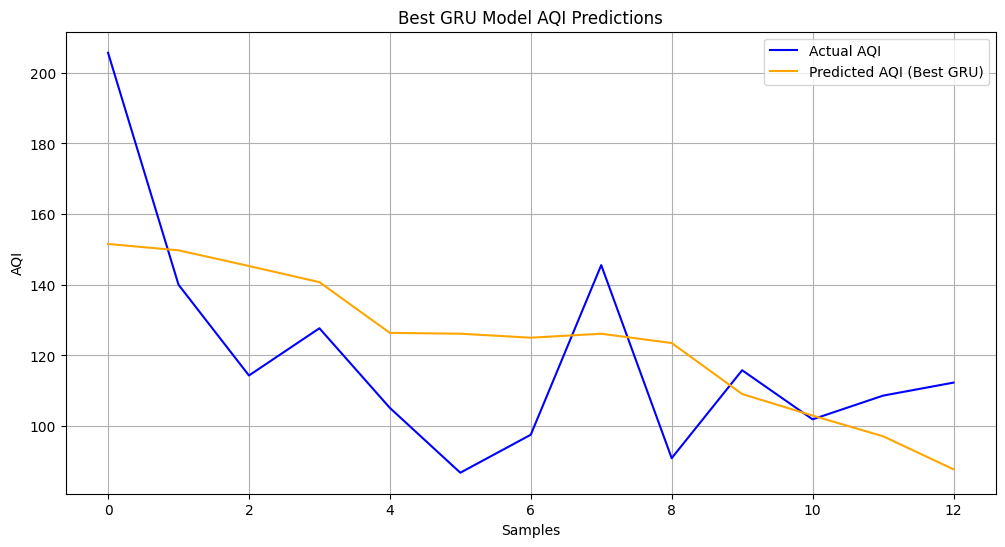

Best GRU predictions plot saved as 'best_gru_predictions.png'


<Figure size 640x480 with 0 Axes>

In [33]:
# Plot predictions of the best model
best_model_predictions = best_model.predict(X_test_seq)
best_model_predictions = scaler_target.inverse_transform(best_model_predictions)  # Rescale predictions
y_test_actual = scaler_target.inverse_transform(y_test_seq)  # Rescale actual values

# Plotting the best model predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual AQI', color='blue')
plt.plot(best_model_predictions, label='Predicted AQI (Best GRU)', color='orange')
plt.title('Best GRU Model AQI Predictions')
plt.xlabel('Samples')
plt.ylabel('AQI')
plt.legend()
plt.grid()
plt.show()

# Save the plot if needed
plt.savefig('best_gru_predictions.png')
print("Best GRU predictions plot saved as 'best_gru_predictions.png'")


## Model 4.2: LSTM

In [34]:
from keras.models import Model
from keras.layers import LSTM, Input, Dense, Dropout
from keras.optimizers import Adam

def build_lstm_model(units, dropout_rate, learning_rate, input_shape):
    input_layer = Input(shape=input_shape)  # Explicit input layer
    x = LSTM(units, return_sequences=True)(input_layer)
    x = Dropout(dropout_rate)(x)
    x = LSTM(units)(x)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(1)(x)  # Output layer for regression
    model = Model(inputs=input_layer, outputs=output_layer)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


In [36]:
# Hyperparameter grid for LSTM
param_grid_lstm = {
    'units': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'batch_size': [16, 32, 64],
    'epochs': [20]  # Fixed number of epochs
}


In [37]:
from sklearn.model_selection import ParameterGrid
from keras.callbacks import EarlyStopping

# Initialize variables for tracking the best model
best_lstm_model = None
best_lstm_mae = float('inf')
best_lstm_params = None
lstm_results = []

# Perform Grid Search for LSTM
for params in ParameterGrid(param_grid_lstm):
    print(f"Testing params: {params}")
    model = build_lstm_model(
        units=params['units'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    )
    early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

    # Train the LSTM model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0,
        callbacks=[early_stopping]
    )

    # Evaluate the model
    predictions = model.predict(X_test_seq)
    predictions = scaler_target.inverse_transform(predictions)
    y_test_actual = scaler_target.inverse_transform(y_test_seq)
    mae = mean_absolute_error(y_test_actual, predictions)
    rmse = math.sqrt(mean_squared_error(y_test_actual, predictions))

    print(f"MAE: {mae}, RMSE: {rmse}")
    lstm_results.append((params, mae, rmse))

    # Track the best model
    if mae < best_lstm_mae:
        best_lstm_mae = mae
        best_lstm_model = model
        best_lstm_params = params

# Display the best parameters
print("Best LSTM Parameters:")
print(best_lstm_params)
print(f"Best LSTM MAE: {best_lstm_mae}")




Testing params: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'units': 32}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
MAE: 71.15634059353967, RMSE: 75.66754841999737
Testing params: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'units': 64}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
MAE: 63.36736729876803, RMSE: 66.82502822182228
Testing params: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'units': 128}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
MAE: 59.42452554884315, RMSE: 63.56007385495636
Testing params: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.0005, 'units': 32}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
MAE: 52.28594640033054, RMSE: 55.628909621409086
Testing params: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.0005, 'units': 64}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
MAE: 72.05279622758414, RMSE: 75.58282383107321
Testing params: {'batch_si

In [38]:
# Save results
lstm_results_df = pd.DataFrame(lstm_results, columns=['Params', 'MAE', 'RMSE'])
lstm_results_df.to_csv('lstm_hyperparameter_tuning_results.csv', index=False)
print("LSTM results saved to 'lstm_hyperparameter_tuning_results.csv'")

LSTM results saved to 'lstm_hyperparameter_tuning_results.csv'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


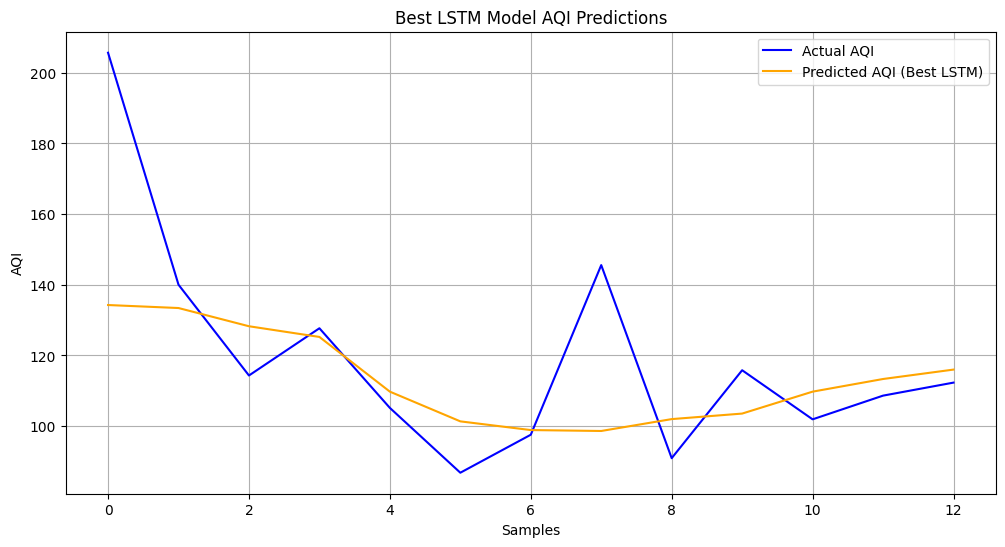

Best LSTM predictions plot saved as 'best_lstm_predictions.png'


<Figure size 640x480 with 0 Axes>

In [39]:
# Plot predictions of the best LSTM model
best_lstm_predictions = best_lstm_model.predict(X_test_seq)
best_lstm_predictions = scaler_target.inverse_transform(best_lstm_predictions)  # Rescale predictions
y_test_actual = scaler_target.inverse_transform(y_test_seq)  # Rescale actual values

# Plotting the best LSTM model predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual AQI', color='blue')
plt.plot(best_lstm_predictions, label='Predicted AQI (Best LSTM)', color='orange')
plt.title('Best LSTM Model AQI Predictions')
plt.xlabel('Samples')
plt.ylabel('AQI')
plt.legend()
plt.grid()
plt.show()

# Save the plot if needed
plt.savefig('best_lstm_predictions.png')
print("Best LSTM predictions plot saved as 'best_lstm_predictions.png'")
